In [1]:
from __future__ import print_function
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

## Generate Periodic Signal

#### 1. Generate with specified latent dynamic model (nonlinear everywhere)

In [2]:
# Nonlinear functions (Input can be arrays)
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def sq(x):
    return x ** 2


def sqrtplus(x):
    sgn = np.sign(x)
    y = np.multiply(sgn, np.sqrt(np.absolute(x)))
    return y


def const_zero(x):
    return np.zeros(len(x))

def twosin2_point1(x):
    return 2 * np.sin(2*x) - 0.1

In [3]:
class TwoFuncSamp():
    def __init__(self, n_obs, obs_dim, fh1, fh2, fob1, fob2, coef_fh1, coef_fh2, coef_fob1, coef_fob2):
        
        self.h_dim = 2
        self.fh1 = fh1
        self.fh2 = fh2
        self.fob1 = fob1
        self.fob2 = fob2
        self.coef_fh1 = coef_fh1
        self.coef_fh2 = coef_fh2
        self.coef_fob1 = coef_fob1
        self.coef_fob2 = coef_fob2
        
        # Initial state multivariate normal with mean = 0.1 and covariance matrix = Diag(2)
        self.obs_dim = obs_dim
        self.n_obs = n_obs
        self.h_dim = 2
        self.initial_mean = np.array([0, 0.5])
        self.initial_log_diag_sq = np.log(np.array([1, 1.1]))

        
        # Dimension transformation from latent to observation
        self.emit_mat = np.random.uniform(1/2, 3/2, self.h_dim).reshape(self.h_dim, 1)
        
    
    def sample_all(self, n_timesteps, random_seed = None):
        mus = np.zeros([n_timesteps, self.h_dim])
        log_diag_sigmas = np.zeros([n_timesteps, self.h_dim])
        observations = np.zeros([n_timesteps, self.n_obs, self.obs_dim])
        
        if random_seed is not None:
            np.random.seed(random_seed)

        # Initialize hidden mean and diagonal entries of covariance matrix (with small Gaussian noise)
        mus[0, :] = self.coef_fh1 * self.fh1(self.initial_mean) + self.coef_fh2 * self.fh2(self.initial_mean) + 0.1 * np.random.normal(0, 1, self.h_dim)
        log_diag_sigmas[0, :] = self.coef_fh1 * self.fh1(self.initial_log_diag_sq) + self.coef_fh2 * self.fh2(self.initial_log_diag_sq) + 0.1 * np.random.normal(0, 1, self.h_dim)
        
        # Initialize observation (Latent is Gaussian, linear transform to modify dimension)
        for j in range(self.n_obs):
            samp_h = np.random.multivariate_normal(mus[0, :], np.diag(np.exp(log_diag_sigmas[0, :])), self.obs_dim)
            pre_samp_obs = np.dot(samp_h, self.emit_mat)
            temp = self.coef_fob1 * self.fob1(pre_samp_obs) + self.coef_fob2 * self.fob2(pre_samp_obs)
            temp = temp.flatten()
            observations[0, j, :] = temp + np.random.normal(0, 1, self.obs_dim)
        
        for i in range(1, n_timesteps):
            # Update hidden mean and diagonal entries of covariance matrix at time step i (with small Gaussian noise)
            mus[i, :] = self.coef_fh1 * self.fh1(mus[i - 1, :]) + self.coef_fh2 * self.fh2(mus[i - 1, :]) + 0.1 * np.random.normal(0, 1, self.h_dim)
            log_diag_sigmas[i, :] = self.coef_fh1 * self.fh1(log_diag_sigmas[i - 1, :]) + self.coef_fh2 * self.fh2(log_diag_sigmas[i - 1, :]) + 0.1 * np.random.normal(0, 1, self.h_dim)
            
            # Generate a series of observation vectors
            for j in range(self.n_obs):
                samp_h = np.random.multivariate_normal(mus[i, :], np.diag(np.exp(log_diag_sigmas[i, :])), self.obs_dim)
                pre_samp_obs = np.dot(samp_h, self.emit_mat)
                temp = self.coef_fob1 * self.fob1(pre_samp_obs) + self.coef_fob2 * self.fob2(pre_samp_obs)
                temp = temp.flatten()
                observations[i, j, :] = temp + np.random.normal(0, 1, self.obs_dim)
        return mus, log_diag_sigmas, observations


In [4]:
# Sampler following CS's suggestion
class PeriodicSamp():
    def __init__(self, n_obs, obs_dim, f_hidden, coef_fh):
        self.h_dim = 2
        self.obs_dim = obs_dim
        self.fh = f_hidden
        self.coef_fh = coef_fh
        
        # Initial state multivariate normal with mean = 0.1 and covariance matrix = Diag(2)
        self.n_obs = n_obs
        self.initial_state = np.random.multivariate_normal(np.zeros(self.h_dim), np.eye(self.h_dim), self.n_obs)

        # We do not focus on VAE, therefore the emission function is linear and should be easy to learn.
        self.emission_mat = np.random.uniform(0.1, 5, self.h_dim * self.obs_dim).reshape(self.obs_dim, self.h_dim)
        
    
    def sample_all(self, n_timesteps, random_seed = None):
        latents = np.zeros([n_timesteps, self.n_obs, self.h_dim])
        observations = np.zeros([n_timesteps, self.n_obs, self.obs_dim])
        
        if random_seed is not None:
            np.random.seed(random_seed)

        for i in range(self.n_obs):
          diag_h = np.random.uniform(1, 5, self.h_dim)
          diag_o = np.random.uniform(1, 5, self.obs_dim)

          # Hidden state is multivariate Gaussian plus iid Gaussian noise
          latents[0, i, :] = np.random.multivariate_normal(self.coef_fh * self.fh(self.initial_state[i]), 0.01 * np.diag(diag_h))
          # Initialize observation (linear transformation + Gaussian noise)
          observations[0, i, :] = np.matmul(self.emission_mat, latents[0, i, :]) + 0.1 * np.random.multivariate_normal(np.zeros(self.obs_dim), np.diag(diag_o))   
        
        for t in range(1, n_timesteps):
            for i in range(self.n_obs):
              diag_h = np.random.uniform(1, 5, self.h_dim)
              diag_o = np.random.uniform(1, 5, self.obs_dim)
              # Hidden state is multivariate Gaussian plus iid Gaussian noise
              latents[t, i, :] = np.random.multivariate_normal(self.coef_fh * self.fh(latents[t - 1, i, :]), 0.01 * np.diag(diag_h))
              # Initialize observation (linear transformation + Gaussian noise)
              observations[t, i, :] = np.matmul(self.emission_mat, latents[t, i, :]) + 0.1 * np.random.multivariate_normal(np.zeros(self.obs_dim), np.diag(diag_o))
        return latents, observations


In [5]:
h_dim = 2
obs_dim = 50
n_obs = 1000
n_timestep = 10

sampler2 = PeriodicSamp(n_obs, obs_dim, np.cos, 2)

In [6]:
latents, obs = sampler2.sample_all(n_timestep)

In [7]:
print(obs.shape)

(10, 1000, 50)


In [8]:
obs = np.transpose(obs, (1, 0, 2))
print(obs.shape)

(1000, 10, 50)


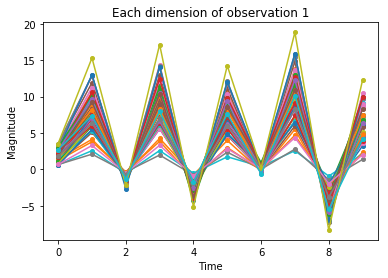

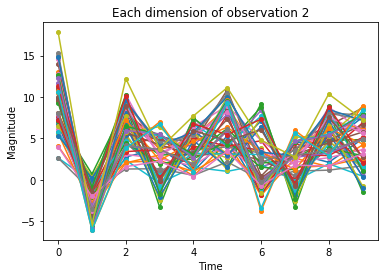

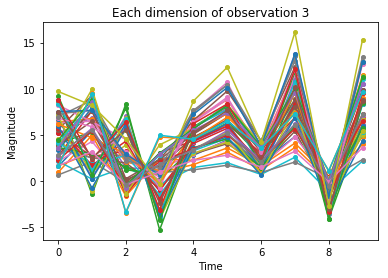

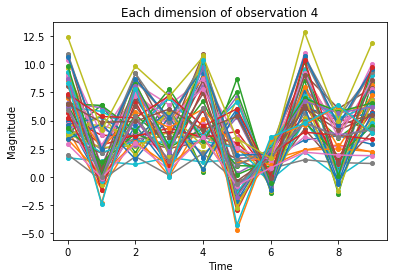

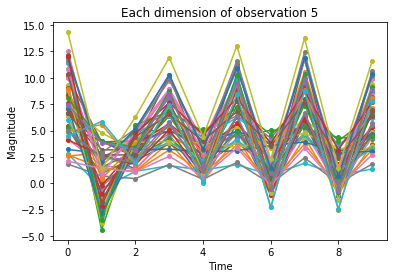

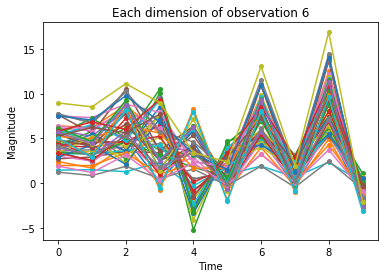

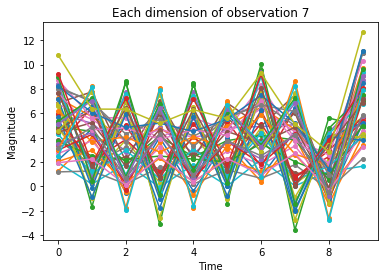

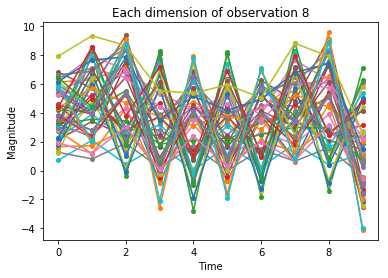

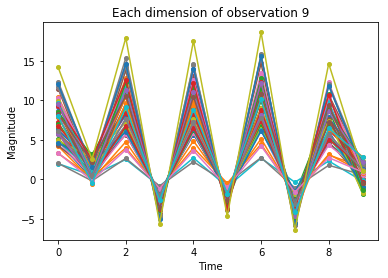

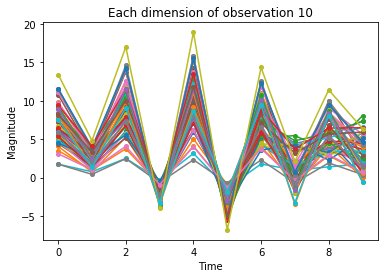

In [9]:
# Plot the temporal trend for each dimension of first five observations
x1 = np.arange(n_timestep)
for n in range(10):
    for i in range(sampler2.obs_dim):
        plt.plot(x1, obs[n, :, i], marker = 'o', markersize = 4)

    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.title('Each dimension of observation '+ str(n + 1));
    plt.show()

In [10]:
X_range = np.arange(0, 9)
Y_range = np.arange(1, 10)
X = obs[:, X_range, :]
Y = obs[:, Y_range, :]

In [11]:
print(X.shape)
print(Y.shape)

(1000, 9, 50)
(1000, 9, 50)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [13]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(800, 9, 50) (800, 9, 50) (200, 9, 50) (200, 9, 50)


In [14]:
train_X = X_train.reshape(-1, obs_dim)
test_X = X_test.reshape(-1, obs_dim)
train_Y = Y_train.reshape(-1, obs_dim)
test_Y = Y_test.reshape(-1, obs_dim)

In [15]:
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(7200, 50) (7200, 50) (1800, 50) (1800, 50)


In [16]:
train_X_small = train_X[0: 5]
test_X_small = test_X[0: 2]
train_Y_small = train_Y[0: 5]
test_Y_small = test_Y[0: 2]

## Prepare Dataset

In [17]:
batch_size = 16
seed = 1
epochs = 400
cuda = True
log_interval = 10
h_d = 16
l_d = 8


device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}

"""

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)



test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

"""

"\n\ntrain_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('./data', train=True, download=True,\n                   transform=transforms.ToTensor()),\n    batch_size=batch_size, shuffle=True, **kwargs)\n\n\n\ntest_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),\n    batch_size=batch_size, shuffle=True, **kwargs)\n\n"

#### Dataset Object

In [18]:
class SignalData():
    def __init__(self, train_obs, train_tar, test_obs, test_tar, test = False, transform = None):
        self.test = test
        self.transform = transform

        if (self.test == False):
          self.obs = torch.from_numpy(train_obs).float()
          self.targets = torch.from_numpy(train_tar).float()

        else:      
          self.obs = test_obs
          self.targets = test_tar

    def __len__(self):
        return len(self.obs)
    
    def __getitem__(self, index):
        if self.transform is not None:
            ob = self.transform(self.obs[index])
            tar = self.transform(self.targets[index])
        else:
            ob = self.obs[index]
            tar = self.targets[index]
        return ob, tar

### Create Dataloader

In [19]:
train_set = SignalData(train_X, train_Y, test_X, test_Y, test = False, transform = None)
test_set = SignalData(train_X, train_Y, test_X, test_Y, test = True, transform = None)

In [20]:
train_set_small = SignalData(train_X_small, train_Y_small, test_X_small, test_Y_small, test = False, transform = None)
test_set_small = SignalData(train_X_small, train_Y_small, test_X_small, test_Y_small, test = True, transform = None)

In [21]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle = False, **kwargs)

In [22]:
train_loader_small = torch.utils.data.DataLoader(train_set_small, batch_size=1, shuffle = True, **kwargs)
test_loader_small = torch.utils.data.DataLoader(test_set_small, batch_size=1, shuffle = False, **kwargs)

### Model Definition

In [23]:

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(50, h_d)
        self.fc21 = nn.Linear(h_d, l_d)
        self.fc22 = nn.Linear(h_d, l_d)
        
        # Transition layer
        self.fct = nn.Linear(l_d, l_d)
        self.fctm = nn.Linear(l_d, l_d)
        self.fcts = nn.Linear(l_d, l_d)
        
        # Decoder should also be a probability distribution
        self.fc3 = nn.Linear(l_d, h_d)
        self.fc4 = nn.Linear(h_d, 50)
        self.fc5 = nn.Linear(h_d, 50)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize1(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def transition(self, z):
        h2 = F.relu(self.fct(z))
        return self.fctm(h2), self.fcts(h2)
    
    def reparameterize2(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.tanh(self.fc3(z))
        return self.fc4(h3), self.fc5(h3)

    def forward(self, x):
        mu1, logvar1 = self.encode(x)
        z1 = self.reparameterize1(mu1, logvar1)
        mu2, logvar2 = self.transition(z1)
        z2 = self.reparameterize2(mu2, logvar2)
        mu_obs, logvar_obs = self.decode(z2)
        
        return mu_obs, logvar_obs, mu2, logvar2

In [24]:
model = VAE().to(device)
#adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [30]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x, mu_obs, logvar_obs, mu, logvar):
    covar = torch.diag_embed(torch.exp(logvar_obs))
    n = torch.distributions.MultivariateNormal(mu_obs, covariance_matrix = covar)
    neg_llh = torch.sum(-n.log_prob(x))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return neg_llh + KLD

### Define training and testing algorithm

In [31]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (obs, target) in enumerate(train_loader):
        obs = obs.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        mu_obs, logvar_obs, mu, logvar = model(obs.float())
        loss = loss_function(target.float(), mu_obs, logvar_obs, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % log_interval == 0:
         #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          #      epoch, batch_idx * len(img), len(train_loader.dataset),
           #     100. * batch_idx / len(train_loader),
            #    loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss

In [32]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (obs, target) in enumerate(test_loader):
            obs = obs.to(device)
            target = target.to(device)
            mu_obs, logvar_obs, mu, logvar = model(obs.float())
            test_loss += loss_function(target.float(), mu_obs, logvar_obs, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

### Run Training

In [33]:
train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    


====> Epoch: 1 Average loss: 225.0883
====> Test set loss: 151.7949
====> Epoch: 2 Average loss: 148.8374
====> Test set loss: 143.9918
====> Epoch: 3 Average loss: 143.2260
====> Test set loss: 141.5750
====> Epoch: 4 Average loss: 141.1851
====> Test set loss: 139.9386
====> Epoch: 5 Average loss: 140.3575
====> Test set loss: 139.0973
====> Epoch: 6 Average loss: 139.3212
====> Test set loss: 138.3545
====> Epoch: 7 Average loss: 136.4037
====> Test set loss: 130.3744
====> Epoch: 8 Average loss: 119.2074
====> Test set loss: 107.8741
====> Epoch: 9 Average loss: 100.8532
====> Test set loss: 90.8502
====> Epoch: 10 Average loss: 81.4604
====> Test set loss: 75.6664
====> Epoch: 11 Average loss: 71.9353
====> Test set loss: 69.9275
====> Epoch: 12 Average loss: 69.3176
====> Test set loss: 67.9237
====> Epoch: 13 Average loss: 67.6363
====> Test set loss: 65.8369
====> Epoch: 14 Average loss: 67.1213
====> Test set loss: 64.4524
====> Epoch: 15 Average loss: 66.3502
====> Test set l

KeyboardInterrupt: 

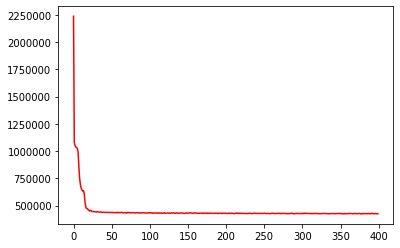

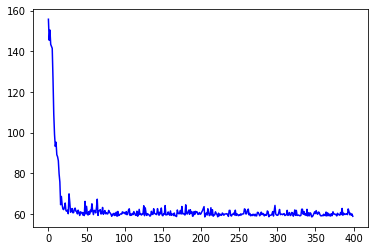

In [87]:
plt.plot(np.array(train_losses),'r')
plt.show()
plt.plot(np.array(test_losses),'b')
plt.show()

### Sample from trained model

In [88]:
print(np.array(train_losses))

[2236166.27661133 1080165.47021484 1049474.18505859 1037371.88452148
 1032590.26220703 1025142.44360352  988038.51049805  854478.62316895
  749421.94128418  691465.63476562  659930.73254395  645388.53222656
  633804.06933594  636710.08728027  610494.35290527  537262.98028564
  489055.66931152  473924.84155273  471747.04205322  464664.39538574
  457659.49462891  450243.37084961  456478.72009277  454665.05438232
  446413.88580322  444597.84222412  443458.5390625   445013.38165283
  444006.64337158  441788.9296875   440713.21893311  444213.75708008
  442520.57818604  442235.73974609  439943.8671875   440230.5758667
  440956.6852417   437104.64221191  438404.92449951  438271.36743164
  438595.85632324  436506.06030273  437337.28265381  437290.96624756
  438200.97698975  437043.17144775  436542.65490723  436279.66552734
  438211.76629639  437307.36450195  435655.92687988  437694.5123291
  435474.77099609  435028.04217529  435265.23266602  435993.9932251
  433288.065979    437865.32232666  4

In [0]:
#std_n = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eyes(2))
#for i in range(10):
